In [2]:
############################ 0. PREPARATION ############################

#-------------------------- import packages --------------------------
import random
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from itertools import combinations
import seaborn as sns
import copy
import itertools

import tensorflow as tf
import tensorflow_lattice as tfl
import keras
import tf_keras as keras_2 # need keras 2 to fit Lattice model
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Multiply, Add, Embedding, Reshape, Concatenate, Dropout, BatchNormalization, Lambda, Layer, CategoryEncoding
from keras.constraints import Constraint
from keras.callbacks import EarlyStopping
from keras.initializers import Zeros, Constant
from tensorflow.keras.optimizers import Adam, Nadam
import keras_tuner as kt
from keras import regularizers
import keras.ops as ops
from keras.utils import plot_model
from tensorflow.keras.losses import Poisson
from tensorflow.keras.losses import Loss
from keras.metrics import MeanAbsoluteError, RootMeanSquaredError
from keras import backend as K
from scipy.stats import gamma


from pygam import LinearGAM, GAM, s, f, l
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

In [3]:
#-------------------------- generate function --------------------------
# Generate x values in the range -4 to 4
X = np.linspace(-4, 4, 10000)

# Generate a monotonic function with many turning points
y = np.exp(-X) / (1 + X**2)

# Add random noise to the output
noise = np.random.normal(0, 1, size = X.shape)/8
y_noisy = y + noise

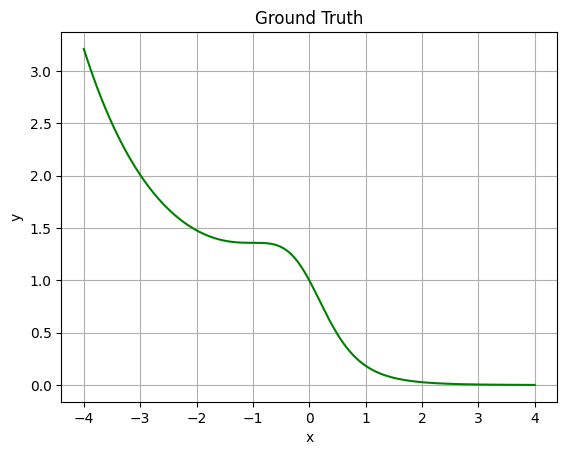

In [4]:
#-------------------------- plot --------------------------
# Ground truth
plt.plot(X, y, color = 'green')
plt.title('Ground Truth')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()

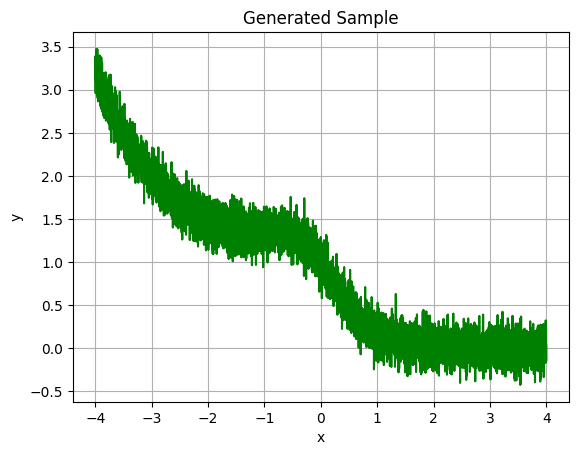

In [5]:
#-------------------------- plot --------------------------
# Generated Sample
plt.plot(X, y_noisy, color = 'green')
plt.title('Generated Sample')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()

In [6]:
#-------------------------- train-test split --------------------------
X_main, X_test, y_main, y_test = train_test_split(
    X, y_noisy, test_size = 0.2, random_state = 1)
X_train, X_val, y_train, y_val = train_test_split(
    X_main, y_main, test_size = 0.25, random_state = 1)

### Lattice

In [7]:
#-------------------------- Lattice --------------------------
lattice_sizes = [2] # lattice size
input_layer = keras_2.layers.Input(shape = [1], name = 'X') # input layer
calibrator = tfl.layers.PWLCalibration(    
    input_keypoints = np.linspace(X_train.min(), X_train.max(), num = 2), # keypoints
    kernel_regularizer = ('hessian', 0.1, 0), # for smoothness
    monotonicity = 'decreasing', # monotonicity constraint
    # output_min = 0,
    # output_max = lattice_sizes[0] - 1,
    name = 'calibrator'
)(input_layer)
# lattice = tfl.layers.Lattice(lattice_sizes = lattice_sizes, 
#                              monotonicities = ['increasing'], 
#                             # kernel_regularizer = ('torsion', 0.1, 0.5),
#                              name = 'lattice')(calibrator)
# model_lattice = keras_2.models.Model(inputs = input_layer, outputs = lattice)
model_lattice = keras_2.models.Model(inputs = input_layer, outputs = calibrator)
model_lattice.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 X (InputLayer)              [(None, 1)]               0         
                                                                 
 calibrator (PWLCalibration  (None, 1)                 2         
 )                                                               
                                                                 
Total params: 2 (8.00 Byte)
Trainable params: 2 (8.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


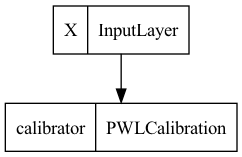

In [8]:
keras_2.utils.plot_model(model_lattice)

In [9]:
#-------------------------- compile and fit Lattice --------------------------
# Compile the model
model_lattice.compile(
    loss = 'mean_squared_error',
    optimizer = 'adam'
)
es = keras_2.callbacks.EarlyStopping(restore_best_weights = True, patience = 10)

# Fit the model
history = model_lattice.fit(
    X_train, y_train,
    epochs = 10_000,
    callbacks = [es],
    validation_data = (X_val, y_val),
    verbose = 1,
    batch_size = 500
)

Epoch 1/10000
12/12 [==============================] - 0s 7ms/step - loss: 1.6616 - val_loss: 1.6653
Epoch 2/10000
12/12 [==============================] - 0s 2ms/step - loss: 1.6395 - val_loss: 1.6432
Epoch 3/10000
12/12 [==============================] - 0s 1ms/step - loss: 1.6178 - val_loss: 1.6216
Epoch 4/10000
12/12 [==============================] - 0s 2ms/step - loss: 1.5965 - val_loss: 1.6004
Epoch 5/10000
12/12 [==============================] - 0s 2ms/step - loss: 1.5755 - val_loss: 1.5796
Epoch 6/10000
12/12 [==============================] - 0s 1ms/step - loss: 1.5549 - val_loss: 1.5593
Epoch 7/10000
12/12 [==============================] - 0s 2ms/step - loss: 1.5349 - val_loss: 1.5393
Epoch 8/10000
12/12 [==============================] - 0s 1ms/step - loss: 1.5152 - val_loss: 1.5196
Epoch 9/10000
12/12 [==============================] - 0s 1ms/step - loss: 1.4959 - val_loss: 1.5005
Epoch 10/10000
12/12 [==============================] - 0s 1ms/step - loss: 1.4771 - val_lo

63/63 [==============================] - 0s 447us/step


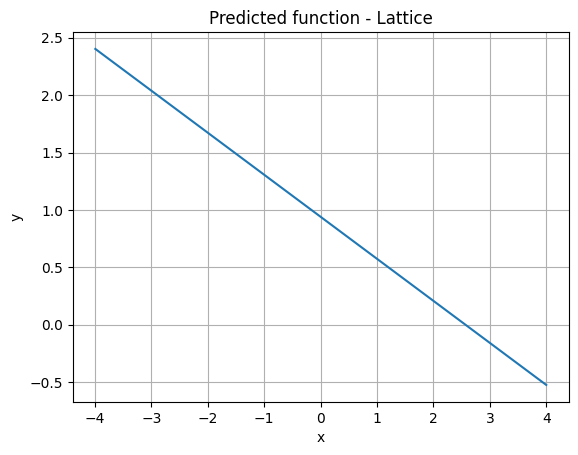

In [10]:
#-------------------------- view the shape function --------------------------
y_pred = model_lattice.predict(X_test)
sns.lineplot(x = X_test, y = y_pred.flatten())
plt.title('Predicted function - Lattice')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()

### MIN-MAX Network

In [11]:
# -------------------------- define specialized layers  --------------------------
'''create a specialized MIN layer'''
class MinLayer(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    def call(self, inputs):
        return ops.min(inputs, axis = -1, keepdims = True)

'''create a specialized MAX layer'''
class MaxLayer(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    def call(self, inputs):
        return ops.max(inputs, axis = -1, keepdims = True)


# -------------------------- define monotonicity constraint --------------------------
# Custom constraint
class MonotonicityConstraint(Constraint):
    
    def __init__(self, monotonicity_list, **kwargs):
        """Examples of monotonicity list: ["positive", "negative", "none"]. This example shows an input of size 3,
        where all weights connecting the first input neuron with the dense layer should always be positive; negative for
        the second neuron and nothing is applied for the third neuron """
        super().__init__(**kwargs)
        self.monotonicity_list = monotonicity_list

    def __call__(self, weights):
        updated_weights = []
        # loop over the weights corresponding to each input feature
        for i in range(weights.shape[0]):
            if self.monotonicity_list[i] == "positive":
                # apply non-negative constraint to all weights from the i-th input feature
                updated_weights.append(ops.relu(weights[i, :]))
            elif self.monotonicity_list[i] == "negative":
                # apply non-positive constraint to all weights from the i-th input feature
                updated_weights.append(-ops.relu(-weights[i, :]))
            else:
                # no constraint for "none"
                updated_weights.append(weights[i, :])
        return ops.stack(updated_weights, axis = 0)

In [12]:
# -------------------------- define the architecture for MIN-MAX network --------------------------
def create_MINMAX(input_layer, num_groups, neurons_per_group, activation, monotonicity_list, model_name = None):

    # Define the architecture of each group
    min_layers = [] # store output of the MIN layer
    input_size = input_layer.shape[1]

    # check consistency in size
    if len(monotonicity_list) != input_size:
        raise ValueError(f"monotonicity_list length {len(monotonicity_list)} does not match input size {input_size}.")

    # create model
    for i in range(num_groups):        
        dense_layer = Dense(neurons_per_group, 
                            activation = activation, 
                            kernel_constraint = MonotonicityConstraint(monotonicity_list))(input_layer)
        
        # Concatenate all neurons and apply MinLayer for the current group
        min_layer = MinLayer()(dense_layer)
        min_layers.append(min_layer)
    
    # concatenate the min values
    concatenated_min_values = Concatenate(axis = -1)(min_layers)
    
    # compute the max of concatenated min values
    output_layer = MaxLayer()(concatenated_min_values)
    
    # create the model
    model = Model(inputs = input_layer, outputs = output_layer, name = model_name)
    return model

In [13]:
#-------------------------- MIN-MAX --------------------------
# hyperparameters
num_groups = 100
neurons_per_group = 100
activation = 'linear'
monotonicity = ['negative']

# model
input_layer = Input(shape = [1], name = 'X') # input layer
model_MM = create_MINMAX(input_layer, num_groups, neurons_per_group, activation, monotonicity)
# plot_model(model_MM)

In [14]:
#-------------------------- compile and fit the model --------------------------
# Compile the model
model_MM.compile(
    loss = 'mean_squared_error',
    optimizer = 'adam'
)
es = EarlyStopping(restore_best_weights = True, patience = 10)

# Fit the model
history = model_MM.fit(
    X_train, y_train,
    epochs = 1000,
    callbacks = [es],
    validation_data = (X_val, y_val),
    verbose = 1
)

Epoch 1/1000


188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 1.6793 - val_loss: 1.0596
Epoch 2/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.9691 - val_loss: 0.7048
Epoch 3/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6264 - val_loss: 0.4777
Epoch 4/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.4346 - val_loss: 0.3266
Epoch 5/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2961 - val_loss: 0.2266
Epoch 6/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2162 - val_loss: 0.1626
Epoch 7/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1576 - val_loss: 0.1227
Epoch 8/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1191 - val_loss: 0.0986
Epoch 9/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0981 - val_loss: 0.0840
Epoch 10/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0855 - val_loss: 0.0755
Epoch 11/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0760 - val_loss: 0.0701
Epoch 12/1000
188/188 ━━━━━━━━━━━━━━━━━━━━

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


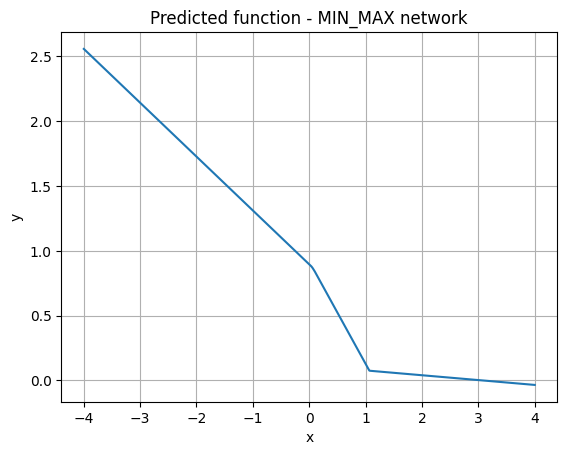

In [15]:
#-------------------------- view the shape function --------------------------
y_pred = model_MM.predict(X_test)
sns.lineplot(x = X_test, y = y_pred.flatten())
plt.title('Predicted function - MIN_MAX network')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()

# Pairwise effect

In [66]:
#-------------------------- generate function --------------------------
np.random.seed(0)
num_samples = 10000

# Generate x values
x1 = np.random.randn(num_samples)
x2 = np.random.randn(num_samples)
X1, X2 = np.meshgrid(np.linspace(x1.min(), x1.max(), 100), np.linspace(x2.min(), x2.max(), 100))

# Generate a monotonic function with many turning points
Y = 0.125 * X1 * np.exp(-0.25 * X2)
# Y = - (X1 + 1) * np.abs(X2 - 0.3)
# Y = np.sin(np.pi * X1 * X2) # test non-monotonic functions

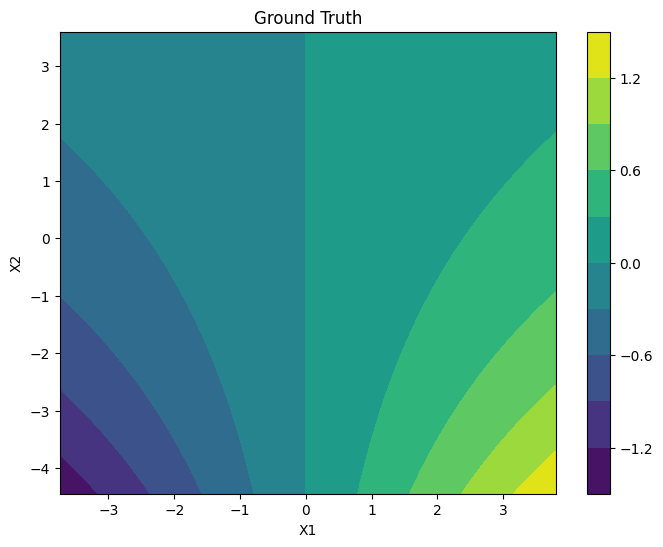

In [67]:
#-------------------------- plot --------------------------
plt.figure(figsize = (8, 6))
plt.contourf(X1, X2, Y, levels = 10)
plt.colorbar()
plt.title('Ground Truth')
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()

In [68]:
#-------------------------- generate sample --------------------------
x = np.vstack((x1, x2)).T
y = 0.125 * x[:,0] * np.exp(-0.25 * x[:,1]) # target
# y = - (x[:,0] + 1) * np.abs(x[:,1] - 0.3) # target
# y = np.sin(np.pi * x[:,0] * x[:,1]) # test non-monotonic functions

# Add random noise to the output
noise = np.random.normal(0, 1, size = x1.shape)/32
y_target = y + noise

In [69]:
#-------------------------- train-test split --------------------------
X_main, X_test, y_main, y_test = train_test_split(
    x, y_target, test_size = 0.2, random_state = 1)
X_train, X_val, y_train, y_val = train_test_split(
    X_main, y_main, test_size = 0.25, random_state = 1)

### Lattice

In [70]:
#-------------------------- Lattice --------------------------
lattice_sizes = [10, 10] # lattice size
model_input = []
lattice_input = []


# input layer
x1_input = keras_2.layers.Input(shape = [1], name = 'input_X1')
x2_input = keras_2.layers.Input(shape = [1], name = 'input_X2')
model_input.append(x1_input)
model_input.append(x2_input)


# calibrator
x1_calibrator = tfl.layers.PWLCalibration(    
    input_keypoints = np.linspace(X_train[:,0].min(), X_train[:,0].max(), num = 200), # keypoints
    kernel_regularizer = ('hessian', 0.001, 0), # for smoothness
    monotonicity = 'increasing', # monotonicity constraint
    output_min = 0,
    output_max = lattice_sizes[0] - 1,
    name = 'calibrator_x1'
)(x1_input)
x2_calibrator = tfl.layers.PWLCalibration(    
    input_keypoints = np.linspace(X_train[:,1].min(), X_train[:,1].max(), num = 200), # keypoints
    kernel_regularizer = ('hessian', 0.001, 0), # for smoothness
    output_min = 0,
    output_max = lattice_sizes[1] - 1,
    name = 'calibrator_x2'
)(x2_input)
lattice_input.append(x1_calibrator)
lattice_input.append(x2_calibrator)


# lattice
lattice = tfl.layers.Lattice(lattice_sizes = lattice_sizes, 
                             monotonicities = ['increasing', 'none'],
                            #  kernel_regularizer = tfl.pwl_calibration_layer.HessianRegularizer(
                            #     l1 = 0.01, l2 = 0),
                             name = 'lattice')(lattice_input)
model_lattice2 = keras_2.models.Model(inputs = model_input, outputs = lattice)
model_lattice2.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_X1 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 input_X2 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 calibrator_x1 (PWLCalibrat  (None, 1)                    200       ['input_X1[0][0]']            
 ion)                                                                                             
                                                                                                  
 calibrator_x2 (PWLCalibrat  (None, 1)                    200       ['input_X2[0][0]']      

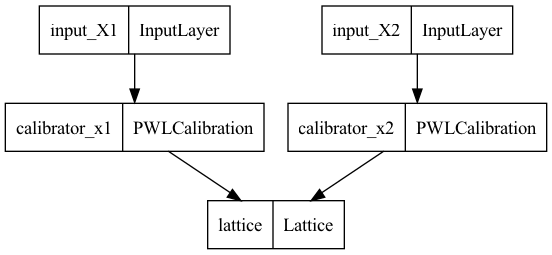

In [71]:
keras_2.utils.plot_model(model_lattice2)

In [72]:
#-------------------------- compile and fit Lattice --------------------------
seed_value = 289
keras_2.utils.set_random_seed(seed_value)

# split the input features
X_train_split = [X_train[:, 0], X_train[:, 1]]
X_val_split = [X_val[:, 0], X_val[:, 1]]
X_test_split = [X_test[:, 0], X_test[:, 1]]

# Compile the model
model_lattice2.compile(
    loss = 'mean_squared_error',
    optimizer = 'adam'
)
es = keras_2.callbacks.EarlyStopping(restore_best_weights = True, patience = 10)

# Fit the model
history = model_lattice2.fit(
    X_train_split, y_train,
    epochs = 10_000,
    callbacks = [es],
    validation_data = (X_val_split, y_val),
    verbose = 1,
    batch_size = 500
)

Epoch 1/10000
12/12 [==============================] - 1s 10ms/step - loss: 0.2174 - val_loss: 0.1473
Epoch 2/10000
12/12 [==============================] - 0s 3ms/step - loss: 0.1052 - val_loss: 0.0642
Epoch 3/10000
12/12 [==============================] - 0s 3ms/step - loss: 0.0433 - val_loss: 0.0259
Epoch 4/10000
12/12 [==============================] - 0s 3ms/step - loss: 0.0185 - val_loss: 0.0141
Epoch 5/10000
12/12 [==============================] - 0s 3ms/step - loss: 0.0119 - val_loss: 0.0113
Epoch 6/10000
12/12 [==============================] - 0s 3ms/step - loss: 0.0097 - val_loss: 0.0091
Epoch 7/10000
12/12 [==============================] - 0s 3ms/step - loss: 0.0076 - val_loss: 0.0069
Epoch 8/10000
12/12 [==============================] - 0s 3ms/step - loss: 0.0058 - val_loss: 0.0053
Epoch 9/10000
12/12 [==============================] - 0s 3ms/step - loss: 0.0046 - val_loss: 0.0043
Epoch 10/10000
12/12 [==============================] - 0s 3ms/step - loss: 0.0037 - val_l

In [73]:
#-------------------------- get prediction --------------------------
# Generate a mesh grid for X1 and X2
x1_range = np.linspace(X_train[:, 0].min(), X_train[:, 0].max(), 100)
x2_range = np.linspace(X_train[:, 1].min(), X_train[:, 1].max(), 100)
X1, X2 = np.meshgrid(x1_range, x2_range)

# Flatten the grid so we can feed it to the model
X1_flat = X1.flatten()
X2_flat = X2.flatten()

# Prepare the grid inputs for the model
grid_inputs = [X1_flat, X2_flat]

# Predict the output (Y values) using the trained model
Y_pred = model_lattice2.predict(grid_inputs, batch_size = 500)

# Reshape the predictions back into the shape of the mesh grid
Y_pred = Y_pred.reshape(X1.shape)

20/20 [==============================] - 0s 920us/step


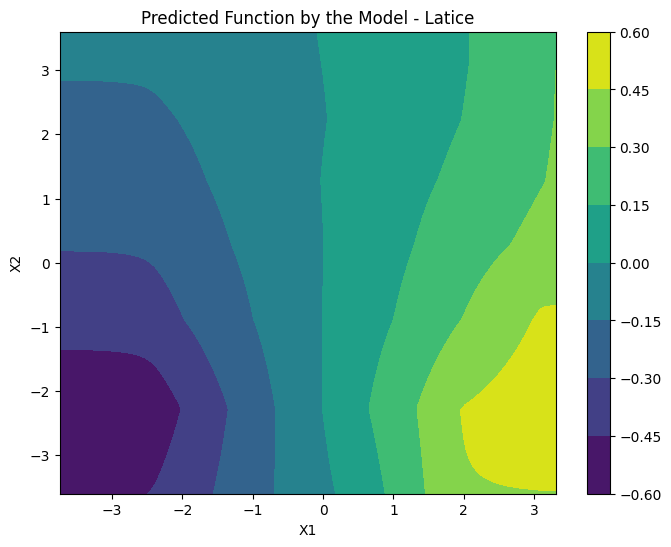

In [74]:
#-------------------------- plot --------------------------
plt.figure(figsize=(8, 6))
contour = plt.contourf(X1, X2, Y_pred, levels = 10)
plt.colorbar(contour)
plt.title('Predicted Function by the Model - Latice')
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()

### MIN-MAX Network

In [75]:
#-------------------------- MIN-MAX --------------------------
# hyperparameters
num_groups = 10
neurons_per_group = 30
activation = 'linear'
monotonicity = ['positive', 'none']

# model
input_layer = Input(shape = [2], name = 'input_layer') # input layer
model_MM2 = create_MINMAX(input_layer, num_groups, neurons_per_group, activation, monotonicity)

In [76]:
#-------------------------- compile and fit the model --------------------------
# Compile the model
model_MM2.compile(
    loss = 'mean_squared_error',
    optimizer = 'adam'
)
es = EarlyStopping(restore_best_weights = True, patience = 10)

# Fit the model
history = model_MM2.fit(
    X_train, y_train,
    epochs = 1_000,
    callbacks = [es],
    validation_data = (X_val, y_val),
    verbose = 1,
    batch_size = 500
)

Epoch 1/1000


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1679 - val_loss: 0.1265
Epoch 2/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1173 - val_loss: 0.1084
Epoch 3/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1004 - val_loss: 0.0926
Epoch 4/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0855 - val_loss: 0.0785
Epoch 5/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0722 - val_loss: 0.0654
Epoch 6/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0599 - val_loss: 0.0533
Epoch 7/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0488 - val_loss: 0.0434
Epoch 8/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0398 - val_loss: 0.0355
Epoch 9/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0326 - val_loss: 0.0292
Epoch 10/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0269 - val_loss: 0.0241
Epoch 11/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0223 - val_loss: 0.0201
Epoch 12/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.01

In [77]:
#-------------------------- get prediction --------------------------
X_combined = np.vstack((X1_flat, X2_flat)).T
Y_pred_MM2 = model_MM2.predict(X_combined, batch_size = 500)

# Reshape the predictions back into the shape of the mesh grid
Y_pred_MM2 = Y_pred_MM2.reshape(X1.shape)

 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step


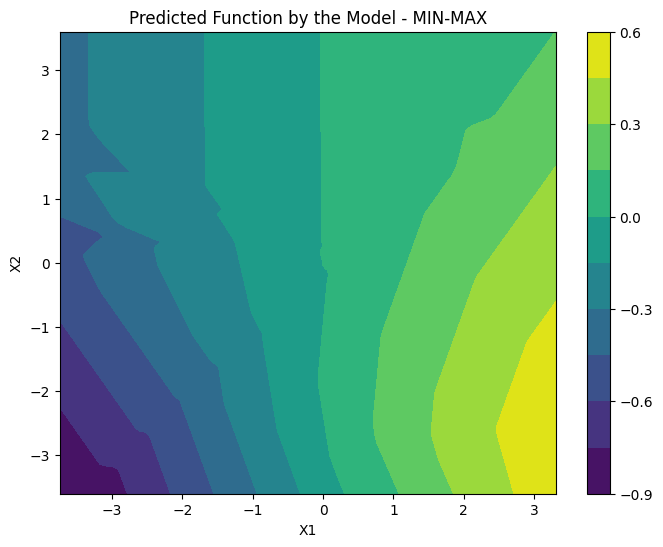

In [78]:
#-------------------------- plot --------------------------
plt.figure(figsize=(8, 6))
contour = plt.contourf(X1, X2, Y_pred_MM2, levels = 10)
plt.colorbar(contour)
plt.title('Predicted Function by the Model - MIN-MAX')
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()

### Neural nets

In [79]:
#-------------------------- define neural nets architecture --------------------------
# hyperparameter
activation = 'leaky_relu'
num_layers = 5
neurons_per_layer = 50
dropout_rate = 0

# define model
model_NN = Sequential()
model_NN.add(Input((2,), name = 'input'))
for i in range(num_layers):
    model_NN.add(Dense(neurons_per_layer, activation = activation))
    model_NN.add(Dropout(dropout_rate))
model_NN.add(Dense(1))

In [80]:
#-------------------------- compile and fit the model --------------------------

# Compile the model
model_NN.compile(
    loss = 'mean_squared_error',
    optimizer = 'adam'
)
es = EarlyStopping(restore_best_weights = True, patience = 10)

# Fit the model
history = model_NN.fit(
    X_train, y_train,
    epochs = 5_000,
    callbacks = [es],
    validation_data = (X_val, y_val),
    verbose = 1,
    batch_size = 500
)

Epoch 1/5000


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0098 - val_loss: 0.0020
Epoch 2/5000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0017 - val_loss: 0.0013
Epoch 3/5000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 4/5000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 5/5000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 6/5000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 7/5000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 8/5000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 9/5000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 10/5000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 11/5000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 12/5000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.00

In [81]:
#-------------------------- get prediction --------------------------
Y_pred_NN = model_NN.predict(X_combined, batch_size = 500)

# Reshape the predictions back into the shape of the mesh grid
Y_pred_NN = Y_pred_NN.reshape(X1.shape)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step


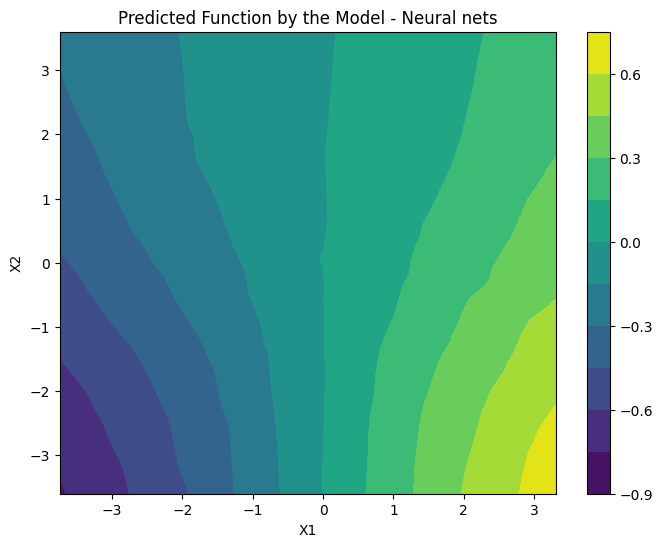

In [82]:
#-------------------------- plot --------------------------
plt.figure(figsize=(8, 6))
contour = plt.contourf(X1, X2, Y_pred_NN, levels = 10)
plt.colorbar(contour)
plt.title('Predicted Function by the Model - Neural nets')
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()